# NB1-es labdarúgó mérkőzések végeredményének előrejelzése gépi tanulással

## **0. Csomagok importálása**

In [ ]:
import pandas as pd
from segedfgek import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split

from SBS import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF

from PlotDecisionRegions import *
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

# to supress warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

## **1. Adatok beolvasása, előkészítése**

Az NB1_elorejelzes_adatgyujtes notebook alapján kigyűjtött adatokat olvassuk be, amit az Eredmények.com oldalról scrapeltünk le. A 2017-18, 2018-19, 2019-20-as szezonokat használtuk fel, az első kettőn fogjuk tanítani a modelleket, majd a 2019-2020-as idény adatain teszteljük a modell, illetve a fogadási stratégia jóságát.

In [ ]:
# lényegében a lescrapelt adatokat letisztítjuk, hogy csak a számok szerepeljenek a pandas táblában
df1920_o=pd.read_csv('.\OTPBankLigaAdatok1920_odds')
df1920_o = df1920_o[::-1]
df1920_o['HLabdabirtoklás'] = df1920_o['HLabdabirtoklás'].map(lambda x: x.rstrip('%'))
df1920_o['ILabdabirtoklás'] = df1920_o['ILabdabirtoklás'].map(lambda x: x.rstrip('%'))
df1920_o['target'] = df1920_o[['HGólok', 'IGólok']].apply(score_to_win, axis = 1)
df1920_o['Dátum'] = '2019' #egyszerűbb a későbbiekben csak a szezon kezdetének évét használni a teljes dátum helyett
hazai_odds_valos = df1920_o['HOdds'].to_list()
dontetlen_odds_valos = df1920_o['DOdds'].to_list()
idegenbeli_odds_valos = df1920_o['VOdds'].to_list()
del df1920_o['DOdds'] # később olyan modellt építünk ami a struktúrájából adódóan nem tud döntetlenre fogadni
df1920_o = df1920_o.rename(columns={"VOdds" : "IOdds"})
df1920_o.head()

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés,HOdds,IOdds,target
197,2019,Újpest,Puskás Akadémia,1,3,70,30,9,9,2,...,9,7,1,45,13,3,1,2.00,3.20,-1
196,2019,Mezőkövesd,Zalaegerszeg,1,0,46,54,11,10,4,...,19,5,5,17,29,3,1,2.05,3.20,1
195,2019,Kisvárda,Paks,1,0,39,61,9,6,3,...,17,8,7,24,30,6,1,2.10,3.25,1
194,2019,MOL Fehérvár FC,Kaposvár,4,2,65,35,13,5,9,...,7,9,3,21,12,1,6,1.20,11.00,1
193,2019,Diósgyőri VTK,Honvéd FC,2,1,48,52,10,11,5,...,15,6,11,20,18,1,1,2.80,2.40,1


In [ ]:
df1718_o=pd.read_csv('.\OTPBankLigaAdatok1718_odds')
df1718_o = df1718_o[::-1]
df1718_o['Dátum'] = '2017'
del df1718_o['DOdds']
df1718_o = df1718_o.rename(columns={"VOdds" : "IOdds"})
df1718_o.head()

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés,HOdds,IOdds
197,2017,Paks,Újpest,2,2,54%,46%,9,10,4,...,23,22,9,1,30,21,0,3,2.75,2.38
196,2017,Debreceni VSC,Mezőkövesd,1,2,48%,52%,18,9,9,...,16,20,8,3,36,22,1,2,1.80,4.20
195,2017,Honvéd FC,Haladás,2,0,54%,46%,7,1,5,...,24,23,7,1,27,23,3,2,1.80,4.50
194,2017,Vasas,Diósgyőri VTK,0,2,47%,53%,8,10,4,...,25,22,2,3,24,35,7,3,1.73,4.75
193,2017,MOL Fehérvár FC,Balmazújváros,1,1,56%,44%,14,8,4,...,19,11,5,2,30,26,1,0,1.33,8.00


In [ ]:
df1819_o=pd.read_csv('.\OTPBankLigaAdatok1819_odds')
df1819_o = df1819_o[::-1]
df1819_o['Dátum'] = '2018'
del df1819_o['DOdds']
df1819_o = df1819_o.rename(columns={"VOdds" : "IOdds"})
df1819_o.head()

,Dátum,HCsapat,ICsapat,HGólok,IGólok,HLabdabirtoklás,ILabdabirtoklás,HKapuraLövés,IKapuraLövés,HKaputEltalálóLövések,...,HSzabadrúgás,ISzabadrúgás,HSzöglet,ISzöglet,HBedobás,IBedobás,HVédés,IVédés,HOdds,IOdds
196,2018,Puskás Akadémia,Debreceni VSC,0,1,49%,51%,4,10,1,...,18,18,4,10,26,24,2,4,2.20,3.4
195,2018,MOL Fehérvár FC,Kisvárda,4,0,51%,49%,19,6,11,...,11,13,8,0,17,14,3,7,1.44,6.5
194,2018,Mezőkövesd,Paks,3,1,49%,51%,9,14,7,...,17,5,5,5,18,21,1,2,2.60,2.7
193,2018,Honvéd FC,Haladás,3,2,55%,45%,18,14,11,...,20,11,6,9,15,23,1,3,1.83,4.2
192,2018,Ferencvárosi TC,Diósgyőri VTK,4,1,57%,43%,21,9,13,...,15,22,12,3,17,17,3,1,1.30,12.0


In [ ]:
train_df_o = pd.concat([df1718_o, df1819_o, df1920_o], ignore_index=True)
train_df_o['HLabdabirtoklás'] = train_df_o['HLabdabirtoklás'].map(lambda x: x.rstrip('%'))
train_df_o['ILabdabirtoklás'] = train_df_o['ILabdabirtoklás'].map(lambda x: x.rstrip('%'))
train_df_o['target'] = train_df_o[['HGólok', 'IGólok']].apply(score_to_win, axis = 1)
train_df_o[["Dátum","HGólok","IGólok","HLabdabirtoklás","ILabdabirtoklás","HKapuraLövés","IKapuraLövés",
"HKaputEltalálóLövések","IKaputEltalálóLövések","HKaputNEMTL","IKaputNEMTL","HSzabadrúgás","ISzabadrúgás","HSzöglet","ISzöglet",
"HBedobás","IBedobás","HVédés","IVédés", "HOdds", "IOdds"]] = train_df_o[["Dátum", "HGólok","IGólok","HLabdabirtoklás","ILabdabirtoklás","HKapuraLövés","IKapuraLövés",
"HKaputEltalálóLövések","IKaputEltalálóLövések","HKaputNEMTL","IKaputNEMTL","HSzabadrúgás","ISzabadrúgás","HSzöglet","ISzöglet",
"HBedobás","IBedobás","HVédés","IVédés", "HOdds", "IOdds"]].apply(pd.to_numeric)
MeccsID = list(range(1, 594))
train_df_o["MeccsID"] = MeccsID
train_df_o.head()

,Dátum,HBedobás,HCsapat,HGólok,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HOdds,HSzabadrúgás,...,IKapuraLövés,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,IOdds,ISzabadrúgás,ISzöglet,IVédés,target,MeccsID
0,2017,30,Paks,2,9,4,5,54,2.75,23,...,10,5,5,46,2.38,22,1,3,0,1
1,2017,36,Debreceni VSC,1,18,9,9,48,1.80,16,...,9,6,3,52,4.20,20,3,2,-1,2
2,2017,27,Honvéd FC,2,7,5,2,54,1.80,24,...,1,0,1,46,4.50,23,1,2,1,3
3,2017,24,Vasas,0,8,4,4,47,1.73,25,...,10,5,5,53,4.75,22,3,3,-1,4
4,2017,30,MOL Fehérvár FC,1,14,4,10,56,1.33,19,...,8,3,5,44,8.00,11,2,0,0,5


In [ ]:
FEATURES_TO_DROP = ['target', 'Dátum', 'HCsapat', 'ICsapat', 'HGólok', 'IGólok'] # ezeket a statokat nem használjuk a tanuláshoz
train_df_wo_o = train_df_o.drop(columns = FEATURES_TO_DROP)
train_df_wo_o.head()

,HBedobás,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HOdds,HSzabadrúgás,HSzöglet,HVédés,IBedobás,IKapuraLövés,IKaputEltalálóLövések,IKaputNEMTL,ILabdabirtoklás,IOdds,ISzabadrúgás,ISzöglet,IVédés,MeccsID
0,30,9,4,5,54,2.75,23,9,0,21,10,5,5,46,2.38,22,1,3,1
1,36,18,9,9,48,1.80,16,8,1,22,9,6,3,52,4.20,20,3,2,2
2,27,7,5,2,54,1.80,24,7,3,23,1,0,1,46,4.50,23,1,2,3
3,24,8,4,4,47,1.73,25,2,7,35,10,5,5,53,4.75,22,3,3,4
4,30,14,4,10,56,1.33,19,5,1,26,8,3,5,44,8.00,11,2,0,5


### Forma feature létrehozása

Nem szerepel a végső modellben, mert nem javítja a teljesítményt. Lényege, hogy exponenciálisan-csökkenő súlyokat társít a csapatok korábbi teljesítményeihez, ahol persze a régebben lejátszott meccsek kapnak egyre kisebb súlyokat.

In [ ]:
eredmenyek = train_df_o[['MeccsID', 'HCsapat', 'ICsapat', 'HGólok', 'IGólok']].values
gol_kul = gd_vectors(eredmenyek)

idegenbeli_forma_exp, hazai_forma_exp = [], []
for meccs in eredmenyek:
    id, hazai_csapat, idegenbeli_csapat, _, _ = meccs
    idegenbeli_forma_exp.append( exponential_momentum(id, idegenbeli_csapat, gol_kul, alpha = .65) )
    hazai_forma_exp.append( exponential_momentum(id, hazai_csapat, gol_kul, alpha = .65) )

train_df_form = train_df_o.copy()
train_df_form['IForma'] = pd.Series(idegenbeli_forma_exp)
train_df_form['HForma'] = pd.Series(hazai_forma_exp)
train_df_form[50:60]

,Dátum,HBedobás,HCsapat,HGólok,HKapuraLövés,HKaputEltalálóLövések,HKaputNEMTL,HLabdabirtoklás,HOdds,HSzabadrúgás,...,IKaputNEMTL,ILabdabirtoklás,IOdds,ISzabadrúgás,ISzöglet,IVédés,target,MeccsID,IForma,HForma
50,2017,22,Haladás,1,8,4,4,54,3.30,14,...,4,46,2.15,9,6,2,1,51,-0.845833,-2.270220
51,2017,29,Diósgyőri VTK,2,9,2,7,57,2.05,23,...,2,43,3.60,20,1,2,-1,52,-1.102144,-0.771560
52,2017,26,Balmazújváros,0,9,3,6,53,2.90,14,...,6,47,2.45,9,3,6,-1,53,1.941704,-0.563353
53,2017,23,Honvéd FC,1,12,4,8,49,2.38,9,...,3,51,2.90,23,4,3,-1,54,1.305622,-0.328516
54,2017,24,Paks,1,5,3,2,51,1.91,19,...,3,49,3.80,16,2,3,1,55,-0.738593,0.468722
55,2017,30,Ferencvárosi TC,2,10,5,5,50,1.44,29,...,4,50,6.50,27,5,3,1,56,-1.446881,1.725686
56,2017,20,Debreceni VSC,3,16,10,6,47,2.60,16,...,2,53,2.60,15,2,3,1,57,1.710479,1.574478
57,2017,30,Mezőkövesd,2,7,3,4,48,3.60,19,...,5,52,2.05,23,5,3,-1,58,-0.924835,-0.738593
58,2017,28,MOL Fehérvár FC,1,10,5,5,50,2.00,16,...,9,50,3.75,17,7,1,0,59,-1.254366,0.076341
59,2017,18,Újpest,1,10,4,6,56,2.05,22,...,6,44,3.50,18,7,1,0,60,2.271764,0.561285


In [ ]:
eredmenyek[50:55]

array([[51, 'Haladás', 'Újpest', 1, 0],
       [52, 'Diósgyőri VTK', 'Paks', 2, 4],
       [53, 'Balmazújváros', 'Debreceni VSC', 0, 1],
       [54, 'Honvéd FC', 'Ferencvárosi TC', 1, 3],
       [55, 'Paks', 'Balmazújváros', 1, 0]], dtype=object)

In [ ]:
id, hazai_csapat, idegenbeli_csapat, _, _ = eredmenyek[50]
exponential_momentum(id, idegenbeli_csapat, gol_kul, alpha = .65)

-0.8458333387023534

### Táblák átalakítása a modell tanításához

A következő technikai átalakításokra azért van szükség, mert egy adott csapat teljesítményét vesszük majd figyelembe a meccsekről, függetlenül az ellenfél erősségétől. Ez egy elég erős elméleti feltételezés, amivel a sportban megjelenő véletlen szerepét igyekeztünk csökkenteni, de persze tisztában vagyunk vele, hogy a gyakorlatban nehéz eltekinteni egy ilyen fontos tényezőtől.

In [ ]:
FEATURES_TO_DROP = ['HBedobás', 'IBedobás', 'HKapuraLövés', 'IKapuraLövés', 'HForma', 'IForma']      
TARGET_PROXIES = ['MeccsID', 'Dátum', 'Csapat', 'Gólok']

In [ ]:
df_c = train_df_form.drop(columns = FEATURES_TO_DROP)
print(list(df_c))

['Dátum', 'HCsapat', 'HGólok', 'HKaputEltalálóLövések', 'HKaputNEMTL', 'HLabdabirtoklás', 'HOdds', 'HSzabadrúgás', 'HSzöglet', 'HVédés', 'ICsapat', 'IGólok', 'IKaputEltalálóLövések', 'IKaputNEMTL', 'ILabdabirtoklás', 'IOdds', 'ISzabadrúgás', 'ISzöglet', 'IVédés', 'target', 'MeccsID']


In [ ]:
hazai_attributumok = ['MeccsID', 'Dátum'] + [a for a in list(df_c) if 'H' in a]
idegenbeli_attributumok = ['MeccsID', 'Dátum'] + [a for a in list(df_c) if 'I' in a]
idegenbeli_attributumok.pop(-1)

print(hazai_attributumok, '\n')
print(idegenbeli_attributumok)

['MeccsID', 'Dátum', 'HCsapat', 'HGólok', 'HKaputEltalálóLövések', 'HKaputNEMTL', 'HLabdabirtoklás', 'HOdds', 'HSzabadrúgás', 'HSzöglet', 'HVédés'] 

['MeccsID', 'Dátum', 'ICsapat', 'IGólok', 'IKaputEltalálóLövések', 'IKaputNEMTL', 'ILabdabirtoklás', 'IOdds', 'ISzabadrúgás', 'ISzöglet', 'IVédés']


In [ ]:
melted = []

for _, row in df_c.iterrows():
    hazai_csapat = [row[attr] for attr in hazai_attributumok] + [1]
    idegenbeli_csapat = [row[attr] for attr in idegenbeli_attributumok] + [0]
    melted.append(hazai_csapat)
    melted.append(idegenbeli_csapat)

print(melted[0])

[1, 2017, 'Paks', 2, 4, 5, 54, 2.75, 23, 9, 0, 1]


In [ ]:
features = ['MeccsID', 'Dátum'] + [a[1:] for a in list(df_c) if 'H' in a] + ['Hazaie']
print(features)

['MeccsID', 'Dátum', 'Csapat', 'Gólok', 'KaputEltalálóLövések', 'KaputNEMTL', 'Labdabirtoklás', 'Odds', 'Szabadrúgás', 'Szöglet', 'Védés', 'Hazaie']


In [ ]:
melted_df = pd.DataFrame(melted, columns = features)
melted_df.head()

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Odds,Szabadrúgás,Szöglet,Védés,Hazaie
0,1,2017,Paks,2,4,5,54,2.75,23,9,0,1
1,1,2017,Újpest,2,5,5,46,2.38,22,1,3,0
2,2,2017,Debreceni VSC,1,9,9,48,1.80,16,8,1,1
3,2,2017,Mezőkövesd,2,6,3,52,4.20,20,3,2,0
4,3,2017,Honvéd FC,2,5,2,54,1.80,24,7,3,1


Végeredményül olyan táblát kapunk, ahol egy adatsor csak egy csapat teljesítményeit részletezi, a 'Hazaie' változó pedig raktározza az információt, amit elvesztettünk az átalakítással, miszerint hazai vagy vendég volt a csapat az adott meccsen.

## **2. Fogadás**

### A tanítás, majd szimuláció

A modellünk alapötlete, hogy a gépi tanulási modelleket betanítjuk a három tanuló szezonon (várható gól modell, illetve a 6 alapstatisztikára épített modell). Majd a tesztszezonban semmi mást nem használunk elég leszimulált meccs után, csak ezeket a modelleket, hogy az egyes meccseken először a korábbi teljesítmények alapján a statisztikákat prediktáljuk előre, majd ezek alapján várható gólokat.

In [ ]:
WINDOW = 10 # hányat veszünk figyelembe az előző meccsek közül a predikció során

In [ ]:
classifiers = [ KNeighborsClassifier(),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB()]

In [ ]:
goal_model = build_exp_goals_model(melted_df, AdaBoostClassifier()) # egy osztályozó jobban szerepelt a gólok számának jóslásakor, emellett 
                                                                    # könnyebb értelmezni a diszkrét események valószínűségét a további elemzéshez

In [ ]:
features_to_drop = ['MeccsID', 'Csapat', 'Dátum', 'Gólok']

In [ ]:
# a várható gólokat előrejelző modell, 
# melynek bemenetei szintén kizárólag prediktált magyarázóváltozók lesznek az első 10 szimulált meccs után
X = melted_df[melted_df.Dátum != 2019].drop(columns = features_to_drop).values
y = melted_df[melted_df.Dátum != 2019]['Gólok'].values
reg = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
reg.fit(X, y)
reg

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# itt szerepelnek a statisztikákra tanuló modellek, melyek több iteráció után kerültek kiválasztásra 
# (legjobb teljesítmény a fogadásnál)
model_map = {'KaputEltalálóLövések': KNeighborsRegressor(n_neighbors=4),
             'KaputNEMTL': KNeighborsRegressor(),
             'Labdabirtoklás': Ridge(alpha=0.5),
             'Szabadrúgás': LassoLars(),
             'Szöglet': KNeighborsRegressor(),
             'Védés': GradientBoostingRegressor()}

for feature, reg in model_map.items():
    model_map[feature] = build_game_stats_model(melted_df, reg, feature)

In [ ]:
st_dev_map = { feature: np.std(melted_df[feature]) for feature in model_map.keys()}
print(st_dev_map)

{'KaputEltalálóLövések': 2.6259980239301774, 'KaputNEMTL': 2.479777530290671, 'Labdabirtoklás': 5.801377983658268, 'Szabadrúgás': 5.120985969227075, 'Szöglet': 2.88070864431363, 'Védés': 2.236762410317797}


In [ ]:
simulated_df = melted_df[melted_df.Dátum == 2018]
simulated_df.head()
print(simulated_df.Csapat.unique())

['Puskás Akadémia' 'Debreceni VSC' 'MOL Fehérvár FC' 'Kisvárda'
 'Mezőkövesd' 'Paks' 'Honvéd FC' 'Haladás' 'Ferencvárosi TC'
 'Diósgyőri VTK' 'Újpest' 'MTK Budapest']


In [ ]:
season_df = melted_df[melted_df.Dátum == 2019].drop(columns = list(model_map.keys()) + ['Gólok'])
season_df.head()

,MeccsID,Dátum,Csapat,Odds,Hazaie
790,396,2019,Újpest,2.00,1
791,396,2019,Puskás Akadémia,3.20,0
792,397,2019,Mezőkövesd,2.05,1
793,397,2019,Zalaegerszeg,3.20,0
794,398,2019,Kisvárda,2.10,1


In [ ]:
for row in season_df.iterrows():
    game = row[1]
    simulated_result = fit_game(game, simulated_df, model_map, goal_model, st_dev_map)
    simulated_df = simulated_df.append(simulated_result, ignore_index = True)
    
print(simulated_df.tail()) # példa egy szimulációra

     MeccsID  Dátum           Csapat  Gólok  KaputEltalálóLövések  KaputNEMTL  \
785      591   2019             Paks      0              5.587905    4.158414   
786      592   2019  Puskás Akadémia      4              4.560618    0.000000   
787      592   2019        Honvéd FC      1              8.524475    2.834808   
788      593   2019  Ferencvárosi TC      0              1.002019    0.950992   
789      593   2019       Mezőkövesd      0              0.000000    5.815332   

     Labdabirtoklás  Odds  Szabadrúgás   Szöglet     Védés  Hazaie  
785       44.597449  3.50    20.886132  0.919775  5.929305       0  
786       51.619975  1.44    26.470350  9.478101  2.536502       1  
787       46.971831  6.50    15.738515  6.879187  0.000000       0  
788       40.197636  1.72    13.537202  4.887698  4.625774       1  
789       40.644066  4.00    18.687568  5.850265  2.407130       0  


In [ ]:
ujszezon_sim = simulated_df[simulated_df.Dátum == 2019]
ujszezon_sim['Gólok']= ujszezon_sim['Gólok'].astype(str)
ujszezon_sim.head()

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Odds,Szabadrúgás,Szöglet,Védés,Hazaie
394,396,2019,Újpest,1,9.031566,7.187097,54.630569,2.00,8.748229,3.173124,4.034325,1
395,396,2019,Puskás Akadémia,0,6.798379,2.523391,56.795874,3.20,15.421862,5.053874,6.595611,0
396,397,2019,Mezőkövesd,1,2.374547,2.154822,49.828718,2.05,25.905769,4.198682,3.058529,1
397,397,2019,Zalaegerszeg,0,1.292169,1.067988,45.488485,3.20,20.188135,7.231682,4.165542,0
398,398,2019,Kisvárda,2,2.809980,3.498167,65.837480,2.10,16.365595,5.066092,5.695083,1


In [ ]:
simulated_df = melted_df[melted_df.Dátum == 2018]

In [ ]:
for row in ujszezon_sim.iterrows():
    game = row[1]
    new_row = {'MeccsID': game.MeccsID, 'Csapat': game.Csapat, 'Dátum': game.Dátum, 'Gólok': None, 'KaputEltalálóLövések': game.KaputEltalálóLövések, 'KaputNEMTL': game.KaputNEMTL, 'Labdabirtoklás': game.Labdabirtoklás, 'Odds':game.Odds, 'Szabadrúgás': game.Szabadrúgás, 'Szöglet': game.Szöglet, 'Védés': game.Védés, 'Hazaie': game.Hazaie}
    goal_features = ['KaputEltalálóLövések', 'KaputNEMTL', 'Labdabirtoklás', 'Odds', 'Szabadrúgás', 'Szöglet', 'Védés', 'Hazaie']
    X_score_as_list = [ new_row[feature] for feature in goal_features ]
    X_score = np.array(X_score_as_list).reshape(1,-1)
    new_row['Gólok'] = int(goal_model.predict(X_score)[0])
    new_row['Góloddsok'] = goal_model.predict_proba(X_score)[0]
    simulated_df = simulated_df.append(new_row, ignore_index = True)

In [ ]:
simulated_df.tail()

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Odds,Szabadrúgás,Szöglet,Védés,Hazaie,Góloddsok
785,591,2019,Paks,0,5.587905,4.158414,44.597449,3.50,20.886132,0.919775,5.929305,0,"[0.3119867056056838, 0.14491364906411525, 0.16..."
786,592,2019,Puskás Akadémia,4,4.560618,0.000000,51.619975,1.44,26.470350,9.478101,2.536502,1,"[0.12033488778892341, 0.20458923743172944, 0.2..."
787,592,2019,Honvéd FC,1,8.524475,2.834808,46.971831,6.50,15.738515,6.879187,0.000000,0,"[0.1534878759068976, 0.17507928328447886, 0.17..."
788,593,2019,Ferencvárosi TC,0,1.002019,0.950992,40.197636,1.72,13.537202,4.887698,4.625774,1,"[0.27084715107524276, 0.24011450928889305, 0.2..."
789,593,2019,Mezőkövesd,0,0.000000,5.815332,40.644066,4.00,18.687568,5.850265,2.407130,0,"[0.47284253212269967, 0.1744181011452128, 0.18..."


In [ ]:
ujszezon_sim = simulated_df[simulated_df.Dátum == 2019]
ujszezon_sim['Gólok']= ujszezon_sim['Gólok'].astype(str)
ujszezon_sim.head()

,MeccsID,Dátum,Csapat,Gólok,KaputEltalálóLövések,KaputNEMTL,Labdabirtoklás,Odds,Szabadrúgás,Szöglet,Védés,Hazaie,Góloddsok
394,396,2019,Újpest,1,9.031566,7.187097,54.630569,2.00,8.748229,3.173124,4.034325,1,"[0.06946045743435465, 0.1904221372946778, 0.18..."
395,396,2019,Puskás Akadémia,0,6.798379,2.523391,56.795874,3.20,15.421862,5.053874,6.595611,0,"[0.3119867056056838, 0.14491364906411525, 0.16..."
396,397,2019,Mezőkövesd,1,2.374547,2.154822,49.828718,2.05,25.905769,4.198682,3.058529,1,"[0.25469116951450305, 0.2619107332157657, 0.24..."
397,397,2019,Zalaegerszeg,0,1.292169,1.067988,45.488485,3.20,20.188135,7.231682,4.165542,0,"[0.47284253212269967, 0.1744181011452128, 0.18..."
398,398,2019,Kisvárda,2,2.809980,3.498167,65.837480,2.10,16.365595,5.066092,5.695083,1,"[0.20390471837524307, 0.18181507269977687, 0.2..."


In [ ]:
# a várható gól modell valószínűségei segítségével
print('Az első 4 meccsen az oddsok arra, hogy egy adott csapatt 2,5-nél kevesebb vagy több gólt lő')
print('Újpest 2,5 alatt: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][394][:3].sum())))
print('       2,5 felett: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][394][3:].sum())))
print('Puskás Akadémia 2,5 alatt: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][395][:3].sum())))
print('                2,5 felett: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][395][3:].sum())))
print('Mezőkövesd 2,5 alatt: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][396][:3].sum())))
print('           2,5 felett: '+ str(1/(ujszezon_sim.head(10)['Góloddsok'][396][3:].sum())))
print('Zalaegerszeg 2,5 alatt: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][397][:3].sum())))
print('             2,5 felett: ' + str(1/(ujszezon_sim.head(10)['Góloddsok'][397][3:].sum())))

Az első 4 meccsen az oddsok arra, hogy egy adott csapatt 2,5-nél kevesebb vagy több gólt lő
Újpest 2,5 alatt: 2.252601180439856
       2,5 felett: 1.7983387015880394
Puskás Akadémia 2,5 alatt: 1.5976918819574137
                2,5 felett: 2.6731028648491018
Mezőkövesd 2,5 alatt: 1.317591192013481
           2,5 felett: 4.148701932380893
Zalaegerszeg 2,5 alatt: 1.2060020057276009
             2,5 felett: 5.854321667733239


Még egy olyan fogadási technikát is meg lehetne vizsgálni, ahol a meccsenként 2,5 gól alá/fölé eseményekre fogadunk a modell oddsait figyelembe véve. Erre azonban a dolgozat keretei között már nem jutott időnk.

### Újpest-Puskás Akadémia meccs vizsgálata

Egy meccs kiragadásával nézzük meg miként jutunk el az oddsokhoz a gólvalószínűségekből.

In [ ]:
ujpest_goal_probs = ujszezon_sim.head(10)['Góloddsok'][394]
puskas_goal_probs = ujszezon_sim.head(10)['Góloddsok'][395]

Mint látjuk igen magas 0.1 feletti valószínűséget ad a modell még a 4-5 gólra is mindkét csapat esetén, ami irreálisan magasnak tűnhet. Azonban mivel mi csak a végkimenetelt vizsgáltuk (hazai/vendég győzelem), ez most nem hátráltatott minket.

In [ ]:
print([round(ujpest_goal_probs[i], 5) for i in range(len(ujpest_goal_probs))])
print([round(puskas_goal_probs[i], 5) for i in range(len(puskas_goal_probs))])

[0.06946, 0.19042, 0.18405, 0.18951, 0.18187, 0.18469, 0.0]
[0.31199, 0.14491, 0.169, 0.14204, 0.12764, 0.10442, 0.0]


In [ ]:
result_probs = np.zeros((len(ujpest_goal_probs)-1, len(ujpest_goal_probs)-1))
result_probs

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
for i in range(len(ujpest_goal_probs)-1):
    for j in range(len(puskas_goal_probs)-1):
        result_probs[i][j] = round(np.multiply(ujpest_goal_probs[i], puskas_goal_probs[j]), 5)
result_probs

array([[0.02167, 0.01007, 0.01174, 0.00987, 0.00887, 0.00725],
       [0.05941, 0.02759, 0.03218, 0.02705, 0.02431, 0.01988],
       [0.05742, 0.02667, 0.0311 , 0.02614, 0.02349, 0.01922],
       [0.05912, 0.02746, 0.03203, 0.02692, 0.02419, 0.01979],
       [0.05674, 0.02636, 0.03074, 0.02583, 0.02321, 0.01899],
       [0.05762, 0.02676, 0.03121, 0.02623, 0.02357, 0.01929]])

In [ ]:
H = np.tril(result_probs, k=-1).sum() # alsó háromszögben azok az esetek szerepelnek, amikor a hazai csapat (Újpest) szerez több gólt
D = np.diag(result_probs).sum() # a diagonálisban a döntetlenek
V = np.triu(result_probs, k=1).sum() # a felső háromszögben a több vendéggólt hozó kimenetelek valószínűségei
print(H, D, V, H+D+V)

0.56717 0.14978 0.28304 0.9999899999999999


A megfelelő háromszög mátrixok összegeiből megvannak a végkimenetel valószínűségek, amelyeknek már csak a reciprokát kell vegyük és megkapjuk az oddsokat. Fontos különbség a fogadóirodai oddsokhoz képest, hogy a mi valószínűségeink 1-re adódnak össze, míg a bukmékerek erre rátesznek egy 10%-ot, amivel magukat biztosítják, így az ő oddsaik 'hamis' valószínűségeket reprezentálnak.

In [ ]:
print(1/np.tril(result_probs, k=-1).sum()) 
print(1/np.diag(result_probs).sum())
print(1/np.triu(result_probs, k=1).sum())

1.763139799354691
6.676458806249165
3.533069530808366


### Oddsok beszerzése a fenti módszerrel minden meccsre

In [ ]:
H_odds = []
D_odds = []
I_odds = []
for i in range(394, 789, 2):
    home_goal_probs = ujszezon_sim['Góloddsok'][i]
    away_goal_probs = ujszezon_sim['Góloddsok'][i+1]
    result_probs = np.zeros((len(ujpest_goal_probs)-1, len(ujpest_goal_probs)-1))
    for k in range(len(home_goal_probs)-1):
        for l in range(len(away_goal_probs)-1):
            result_probs[k][l] = round(np.multiply(home_goal_probs[k], away_goal_probs[l]), 5)
    H_odds.append(1/(np.tril(result_probs, k=-1).sum()))
    D_odds.append(1/(np.diag(result_probs).sum()))
    I_odds.append(1/(np.triu(result_probs, k=1).sum()))    

In [ ]:
H_odds[:10]

[1.763139799354691,
 2.033181522446324,
 2.955781508630882,
 1.9614765995841668,
 2.4908461404339057,
 2.870758454383648,
 3.129792494757597,
 2.802533490275209,
 2.0750762590525205,
 1.6631463402464781]

In [ ]:
ujszezon_eredmenyek = ujszezon_sim.groupby('MeccsID')['Gólok'].apply(' '.join).reset_index()
ujszezon_csapatok = ujszezon_sim.groupby('MeccsID')['Csapat'].apply(','.join).reset_index()
ujszezon_csapatok.head()

,MeccsID,Csapat
0,396,"Újpest,Puskás Akadémia"
1,397,"Mezőkövesd,Zalaegerszeg"
2,398,"Kisvárda,Paks"
3,399,"MOL Fehérvár FC,Kaposvár"
4,400,"Diósgyőri VTK,Honvéd FC"


In [ ]:
ujszezon_odds = ujszezon_sim.groupby('MeccsID')['Gólok'].apply(' '.join).reset_index()
ujszezon_odds = ujszezon_sim.groupby('MeccsID')['Csapat'].apply(','.join).reset_index()
ujszezon_odds[['HCsapat','ICsapat']] = ujszezon_csapatok.Csapat.str.split(",",expand=True,)
del ujszezon_odds['Csapat']
ujszezon_odds["Hazai_v"] = hazai_odds_valos # valós oddsok (v=valós)
ujszezon_odds["Döntetlen_v"] = dontetlen_odds_valos
ujszezon_odds["Idegenbeli_v"] = idegenbeli_odds_valos
ujszezon_odds["Hazai_m"] = H_odds #modell oddsok (m=modell)
ujszezon_odds["Döntetlen_m"] = D_odds
ujszezon_odds["Idegenbeli_m"] = I_odds
ujszezon_odds['Eredmény']=list(map(lambda x, y: "H" if x>y else "D" if x==y else "A",
                                        list(df1920_o["HGólok"]), list(df1920_o["IGólok"])))
ujszezon_odds

,MeccsID,HCsapat,ICsapat,Hazai_v,Döntetlen_v,Idegenbeli_v,Hazai_m,Döntetlen_m,Idegenbeli_m,Eredmény
0,396,Újpest,Puskás Akadémia,2.00,3.60,3.20,1.763140,6.676459,3.533070,A
1,397,Mezőkövesd,Zalaegerszeg,2.05,3.50,3.20,2.033182,4.390394,3.566715,H
2,398,Kisvárda,Paks,2.10,3.20,3.25,2.955782,6.026638,2.017186,H
3,399,MOL Fehérvár FC,Kaposvár,1.20,6.00,11.00,1.961477,6.828269,3.113810,H
4,400,Diósgyőri VTK,Honvéd FC,2.80,3.20,2.40,2.490846,5.265929,2.447202,H
5,401,Kaposvár,Mezőkövesd,2.75,3.20,2.40,2.870758,5.774005,2.089995,A
6,402,Diósgyőri VTK,Újpest,3.10,3.20,2.20,3.129792,5.610413,1.990921,A
7,403,Puskás Akadémia,MOL Fehérvár FC,3.40,3.30,2.00,2.802533,4.735745,2.314547,A
8,404,Paks,Honvéd FC,2.75,3.10,2.45,2.075076,5.959476,2.854859,H
9,405,Debreceni VSC,Kisvárda,1.83,3.40,3.90,1.663146,5.451374,4.645113,H


Nézzük meg, valahol találunk-e olyat, hogy a modell oddsa alacsonyabb egy adott kimenetre (kivéve a döntetlenek), mint a fogadóirodai odds. Mivel reciprokot vettünk: alacsonyabb oddsból nagyobb valószínűség következik, azaz itt olyan meccseket keresünk, amelyek kimenetelében lényegesen (ez a küszöbérték is még kérdés volt) biztosabb a mi modellünk. Ha ilyen előáll, akkor fogadjunk erre az eseményre. Folytatható-e nyereségesen ez a fogadási taktika?

In [ ]:
def fogadas(dataframe, fogadasi_osszeg, kulonbseg_kuszob):
    egyenleg = 0
    fogadasok = 0
    for row in ujszezon_odds.iterrows():
        game = row[1]
        if min(game.Hazai_m, game.Döntetlen_m, game.Idegenbeli_m) == game.Hazai_m: # vegyük minden meccsen csak a modellünk szerint legvalószínűbb eseményt
            if (game.Hazai_v-game.Hazai_m) > kulonbseg_kuszob: 
                egyenleg -= fogadasi_osszeg # egy fogadás során egy meccsre fogadunk fogadasi_osszeg forinttal
                fogadasok += 1
                if game.Eredmény == 'H':
                    egyenleg += game.Hazai_v*fogadasi_osszeg
                #print(row)
        if min(game.Hazai_m, game.Döntetlen_m, game.Idegenbeli_m) == game.Idegenbeli_m:
            if (game.Idegenbeli_v-game.Idegenbeli_m) > kulonbseg_kuszob:
                egyenleg -= fogadasi_osszeg 
                fogadasok += 1
                if game.Eredmény == 'A':
                    egyenleg += game.Idegenbeli_v*fogadasi_osszeg
                #print(row)
    print('A végső egyenlegünk ' + str(int(egyenleg)) + ' Ft amit ' + str(fogadasok) + ' db fogadással értünk el.')
    return egyenleg, fogadasok

In [ ]:
fogadas(ujszezon_odds, 10000, 0.13) # 10000 forinttal fogadunk egységesen minden meccsre és 0.13 az az oddskülönbség aminél már fogadunk 

A végső egyenlegünk 198300 Ft amit 87 db fogadással értünk el.


(198300.0, 87)

#### Milyen küszöbértéket érdemes választani?

A végső egyenlegünk 172800 Ft amit 97 db fogadással értünk el.
A végső egyenlegünk 202800 Ft amit 94 db fogadással értünk el.
A végső egyenlegünk 196800 Ft amit 91 db fogadással értünk el.
A végső egyenlegünk 195300 Ft amit 89 db fogadással értünk el.
A végső egyenlegünk 198300 Ft amit 87 db fogadással értünk el.
A végső egyenlegünk 189300 Ft amit 86 db fogadással értünk el.
A végső egyenlegünk 139800 Ft amit 82 db fogadással értünk el.
A végső egyenlegünk 149800 Ft amit 81 db fogadással értünk el.
A végső egyenlegünk 131100 Ft amit 77 db fogadással értünk el.
A végső egyenlegünk 131100 Ft amit 77 db fogadással értünk el.
A végső egyenlegünk 135000 Ft amit 73 db fogadással értünk el.
A végső egyenlegünk 117000 Ft amit 71 db fogadással értünk el.
A végső egyenlegünk 103300 Ft amit 70 db fogadással értünk el.
A végső egyenlegünk 85300 Ft amit 67 db fogadással értünk el.
A végső egyenlegünk 79800 Ft amit 63 db fogadással értünk el.
A végső egyenlegünk 61800 Ft amit 60 db fogadással értünk

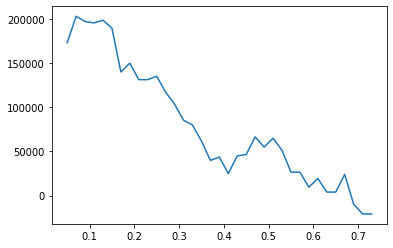

In [ ]:
nyeresegek = []
x = []
for i in range(5, 75, 2):
    nyeresegek.append(fogadas(ujszezon_odds, 10000, i/100)[0])
    x.append(i/100)
plt.plot(x, nyeresegek)
plt.show()

A jelenlegi modellnél a 0.07-es küszöbérték a nyerő, ami elég alacsony, azaz viszonylag sok meccsre fogunk fogadni (94 db).

#### Átlagos nyereség egy fogadáson

Nem lehetne-e kicsit biztosabbra menni, és kevesebb fogadással is hasonló nyereségre szert tenni?

A végső egyenlegünk 172800 Ft amit 97 db fogadással értünk el.
A végső egyenlegünk 172800 Ft amit 97 db fogadással értünk el.
A végső egyenlegünk 202800 Ft amit 94 db fogadással értünk el.
A végső egyenlegünk 202800 Ft amit 94 db fogadással értünk el.
A végső egyenlegünk 196800 Ft amit 91 db fogadással értünk el.
A végső egyenlegünk 196800 Ft amit 91 db fogadással értünk el.
A végső egyenlegünk 195300 Ft amit 89 db fogadással értünk el.
A végső egyenlegünk 195300 Ft amit 89 db fogadással értünk el.
A végső egyenlegünk 198300 Ft amit 87 db fogadással értünk el.
A végső egyenlegünk 198300 Ft amit 87 db fogadással értünk el.
A végső egyenlegünk 189300 Ft amit 86 db fogadással értünk el.
A végső egyenlegünk 189300 Ft amit 86 db fogadással értünk el.
A végső egyenlegünk 139800 Ft amit 82 db fogadással értünk el.
A végső egyenlegünk 139800 Ft amit 82 db fogadással értünk el.
A végső egyenlegünk 149800 Ft amit 81 db fogadással értünk el.
A végső egyenlegünk 149800 Ft amit 81 db fogadással ért

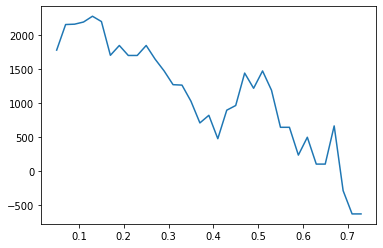

In [ ]:
atlagos_nyeresegek = []
x = []
for i in range(5, 75, 2):
    atlagos_nyeresegek.append(fogadas(ujszezon_odds, 10000, i/100)[0]/fogadas(ujszezon_odds, 10000, i/100)[1])
    x.append(i/100)
plt.plot(x, atlagos_nyeresegek)
plt.show()

Ha szeretnénk elkerülni a szezonok közötti szórások (formaingadozások, új igazolások miatt inkonzisztenciák) miatti veszteségeket, érdemes lehet mégis magasabb küszöböt választani, ami kevesebb fogadással kicsit kevesebbet is hozhat a konyhára, de a fogadásonkénti átlagos hozama jobb így az eljárásunknak (küszöbérték=0.13, ekkor 87 meccsre fogadunk). 

### Modell pontosságának kiértékelése

In [ ]:
ujszezon_eredmenyek = ujszezon_sim.groupby('MeccsID')['Gólok'].apply(' '.join).reset_index()
ujszezon_csapatok = ujszezon_sim.groupby('MeccsID')['Csapat'].apply(','.join).reset_index()
ujszezon_eredmenyek[['HCsapat','ICsapat']] = ujszezon_csapatok.Csapat.str.split(",",expand=True,)
ujszezon_eredmenyek[['HGólok','IGólok']] = ujszezon_eredmenyek.Gólok.str.split(" ",expand=True,)
del ujszezon_eredmenyek['Gólok']
ujszezon_eredmenyek['Eredmények']=list(map(lambda x, y: "H" if x>y else "D" if x==y else "A",
                                        list(df1920_o["HGólok"]), list(df1920_o["IGólok"])))
ujszezon_eredmenyek['Prediktált']=list(map(lambda x, y: "H" if x>y else "D" if x==y else "A",
                                        list(ujszezon_eredmenyek["HGólok"]), list(ujszezon_eredmenyek["IGólok"])))
ujszezon_eredmenyek

,MeccsID,HCsapat,ICsapat,HGólok,IGólok,Eredmények,Prediktált
0,396,Újpest,Puskás Akadémia,1,0,A,H
1,397,Mezőkövesd,Zalaegerszeg,1,0,H,H
2,398,Kisvárda,Paks,2,1,H,H
3,399,MOL Fehérvár FC,Kaposvár,2,0,H,H
4,400,Diósgyőri VTK,Honvéd FC,1,0,H,H
5,401,Kaposvár,Mezőkövesd,0,2,A,A
6,402,Diósgyőri VTK,Újpest,0,2,A,A
7,403,Puskás Akadémia,MOL Fehérvár FC,0,2,A,A
8,404,Paks,Honvéd FC,1,2,H,A
9,405,Debreceni VSC,Kisvárda,2,0,H,H


In [ ]:
print("Az idegenbeli győzelemnek prediktáltak közül valóban mennyi volt idegenben győzelem.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["H"]))
print("Az otthoni győzelemnek prediktáltak közül, valóban mennyi volt otthoni győzelem.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]))
print("--------------------------------------------------------------------------------------------------------------")
print("Az idegenbeli győzelmek közül mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["A"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["A"]))
print("A döntetlenek közül mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["D"]))
print("Az otthoni győzelmek közül valóban mennyit találtunk el.")
print(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]/(pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]))
print("--------------------------------------------------------------------------------------------------------------")
print("Összességében mennyit találtunk el.")
print((pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["H"]["H"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["D"]["D"]+pd.crosstab(ujszezon_eredmenyek.Eredmények, ujszezon_eredmenyek.Prediktált)["A"]["A"])/len(ujszezon_eredmenyek.Eredmények))

Az idegenbeli győzelemnek prediktáltak közül valóban mennyi volt idegenben győzelem.
0.6341463414634146
Az otthoni győzelemnek prediktáltak közül, valóban mennyi volt otthoni győzelem.
0.625
--------------------------------------------------------------------------------------------------------------
Az idegenbeli győzelmek közül mennyit találtunk el.
0.38235294117647056
A döntetlenek közül mennyit találtunk el.
0.45454545454545453
Az otthoni győzelmek közül valóban mennyit találtunk el.
0.6395348837209303
--------------------------------------------------------------------------------------------------------------
Összességében mennyit találtunk el.
0.51010101010101


----------------------------------------------------------------------------------------------------------------